In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from sklearn.preprocessing import StandardScaler
import csv

import matplotlib.pyplot as plt
import pylab
import scipy.stats as stats
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import roc_curve, auc, plot_roc_curve
from collections import Counter


# 1. Linear Regression Analysis for Wine Quality

In [2]:
# Read File
furnace_df = pd.read_csv('MDS_Assignment1_furnace.csv')

In [3]:
furnace_df.shape

(620, 29)

## (1) Results of regression analysis

In [4]:
# Set independent variables and dependent variable
X = furnace_df.drop(['grade'], axis=1)
y = furnace_df['grade']

In [5]:
# Create and fit OLS model
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  grade   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     21.52
Date:                Fri, 22 Oct 2021   Prob (F-statistic):           1.16e-70
Time:                        10:19:55   Log-Likelihood:                -381.52
No. Observations:                 620   AIC:                             819.0
Df Residuals:                     592   BIC:                             943.1
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0339      0.018    110.528      0.0

## (c) Based on the results, rank the independent variables by p-values and which one are statistically significant variables with p-values<0.01

In [6]:
# rank the independent variables by p-values
p_value = results.pvalues.sort_values()
# keep the independent variables with p-values <0.01 only
p_value.where(p_value<0.01).dropna()

const    0.000000e+00
f18      6.355895e-19
f2       2.430368e-18
f14      6.896905e-18
f15      3.971326e-08
f22      4.429125e-04
f17      6.967770e-04
f25      7.041639e-04
f6       6.295708e-03
dtype: float64

## (d)-(1) Testify the assumptions of regression Normality of Variance with respect to residual.

In [7]:
shapiro_test = stats.shapiro(results.resid)
shapiro_test

(0.9345124363899231, 7.536043131996446e-16)

## (d)-(2) Testify the assumptions of regression Independence of Variance with respect to residual.

In [8]:
from statsmodels.stats.stattools import durbin_watson
durbin_watson(results.resid)

2.0040534804722108

## (d)-(3) Testify the assumptions of regression Homogeneity of Variance with respect to residual.

In [9]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
name = ['Lagrange multiplier statistic', 'p-value', 
        'f-value', 'f p-value']
test = sms.het_breuschpagan(results.resid, results.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 140.62034965182627),
 ('p-value', 5.87184293010542e-17),
 ('f-value', 6.43171099963128),
 ('f p-value', 5.3118156753530166e-20)]

---

# 2. Data Preprocessing and Generalized Linear Model (GLM)/Logistic Regression

In [10]:
# Read file
col_names=['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 
           'income'] 
census_df = pd.read_csv('MDS_Assignment1_census.csv', names=col_names, index_col=False)

## (1) and (2) Descriptive statistics

### Data distribution
For numeric columns:
1. count
2. mean
3. std
4. min
5. max
6. 25 percentiles
7. median = 50 percentiles
8. percentiles

In [11]:
# Descriptive statistics of numeric columns
census_df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


For nonnumeric columns:
1. count
2. unique
3. top (the most common value)
4. freq(the most common value’s frequency)

In [12]:
# Descriptive statistics of nonnumeric columns
census_df.describe(exclude=[np.number])

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,income
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


### Handling missing value
According to the data description, the missing value in the dataset has already been converted to "?".
Thus, to count the number of missing value is to count the number of "?" in the dataset.

In [13]:
census_df.isin([' ?']).sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

And we also check the number of NA value

In [14]:
census_df.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

In [15]:
print('number of rows before removing missing value:', census_df.shape[0])

# Remove missing value
census_df.dropna(axis=0, inplace=True)

# Remove the row if there exists one colunm value contains '?'
all_missing_value = census_df.isin([' ?']).any(axis=1)
missing_value_index = all_missing_value[all_missing_value==True]
census_df.drop(missing_value_index.index, inplace=True)

print('number of rows after removing missing value:', census_df.shape[0])

number of rows before removing missing value: 32561
number of rows after removing missing value: 30162


### Outlier detection

Standarization with numeric columns

In [16]:
numeric_cols = census_df.select_dtypes(include=np.number).columns.tolist()
numeric_census_df = census_df[numeric_cols]
ss = StandardScaler()
scaled_df = ss.fit_transform(numeric_census_df)
scaled_df = pd.DataFrame(scaled_df, columns = numeric_cols)

Check histograms and QQ plots of numeric columns, to see if there exists normal distribution in the data and find out the number of outliers.

In [17]:
def plot_histogram(df, col, bincount, title_name, meanStdLine = True, quantileLine = True, savefig = True, outlierCount=True):
    bins = np.linspace(df[col].min(), df[col].max(), 20)
    plt.hist(df[col], bins, alpha=0.5, label=col)
    plt.title(title_name)
    
    # draw mean and mean +- 3*std line in historgram
    if meanStdLine:
        upper_limit = df[col].mean() + 3*df[col].std()
        lower_limit = df[col].mean() - 3*df[col].std()
        plt.axvline(df[col].mean(), linewidth=1, label='mean')
        plt.axvline(lower_limit, linestyle='dashed', linewidth=1.5, label='mean +- 3*std')
        plt.axvline(upper_limit, linestyle='dashed', linewidth=1.5)
        if outlierCount:
            print('Outliers (mean +- 3*std):', (df[(df[col] > upper_limit) | (df[col] < lower_limit)][col]).count())
        
    if quantileLine:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3-q1
        upper_limit = q3+1.5*iqr
        lower_limit = q1-1.5*iqr
        plt.axvline(lower_limit, color='grey', linestyle='dashed', linewidth=1.5, label='q1 - 1.5*iqr')
        plt.axvline(upper_limit, color='grey', linestyle='dashed', linewidth=1.5, label='q3 + 1.5*iqr')
        if outlierCount:
            print('Outliers (q +- 1.5*iqr):', (df[(df[col] > upper_limit) | (df[col] < lower_limit)][col]).count())
    plt.legend()
    # save histogram fig
    if savefig:
        histogram_name = 'data_vis/' + title_name + '_histogram.png'
        plt.savefig(histogram_name)
    
    plt.show()

In [18]:
def plot_QQplot(df, col, title_name, savefig = True):
    stats.probplot(df[col], dist="norm", plot=pylab)
    pylab.title(col)
    
    # save QQ plot fig
    if savefig:
        qqplot_name = 'data_vis/' + title_name + '_qqplot.png'
        pylab.savefig(qqplot_name)
#     
    pylab.show()

=== age ===
Outliers (mean +- 3*std): 120
Outliers (q +- 1.5*iqr): 169


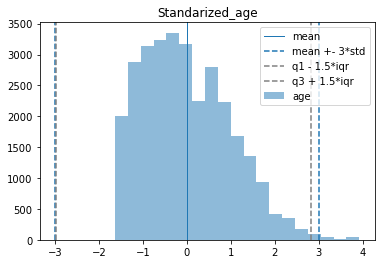

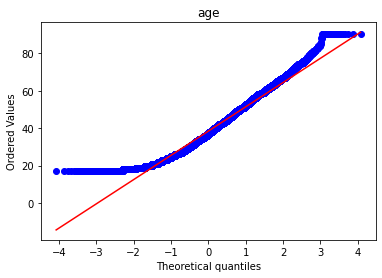

=== fnlwgt ===
Outliers (mean +- 3*std): 322
Outliers (q +- 1.5*iqr): 903


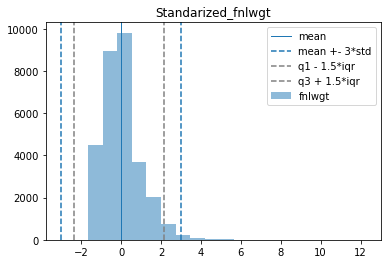

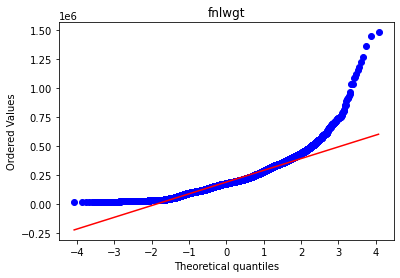

=== education-num ===
Outliers (mean +- 3*std): 196
Outliers (q +- 1.5*iqr): 484


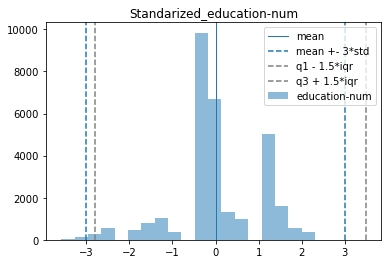

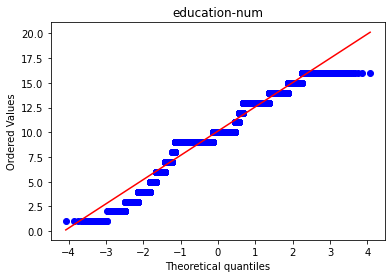

=== capital-gain ===
Outliers (mean +- 3*std): 198
Outliers (q +- 1.5*iqr): 2538


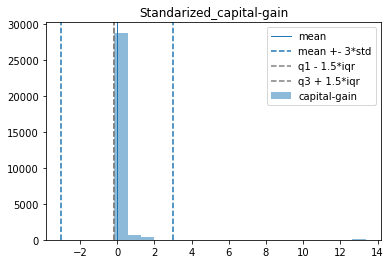

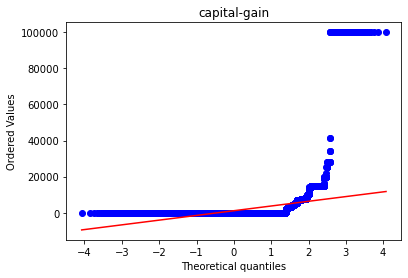

=== capital-loss ===
Outliers (mean +- 3*std): 1381
Outliers (q +- 1.5*iqr): 1427


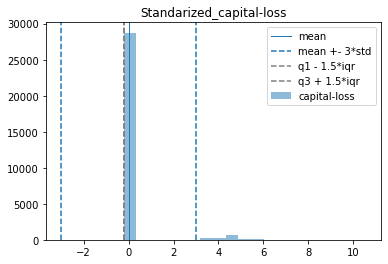

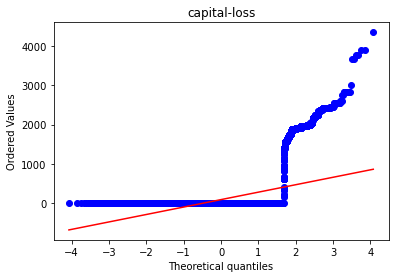

=== hours-per-week ===
Outliers (mean +- 3*std): 402
Outliers (q +- 1.5*iqr): 7953


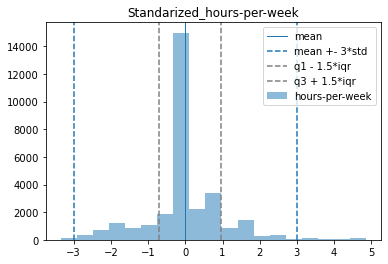

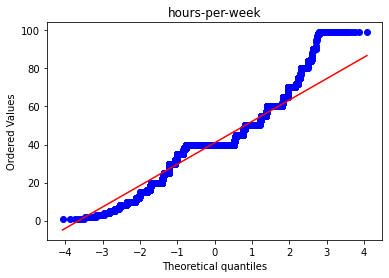

In [19]:
for col in numeric_cols:
    print('===', col, '===')
    histogram_title = 'Standarized_' + col
    plot_histogram(scaled_df, col, 20, histogram_title)
    plot_QQplot(census_df, col, col)
    print('================')

In [20]:
def detect_outliers(df):
    upper_limit = df.mean() + 3*df.std()
    lower_limit = df.mean() - 3*df.std()
    outliers = pd.DataFrame()
    for index,value in enumerate(df.columns):
        outliers[value] = (df.iloc[:,index] < lower_limit[index]) | (df.iloc[:,index] > upper_limit[index])
    return outliers

In [21]:
# Remove the row if at least one column value is outlier
outlier_df = detect_outliers(numeric_census_df)
all_outlier = outlier_df.any(axis=1)
outlier_index = all_outlier[all_outlier==True]
census_df_no_outlier = census_df.drop(outlier_index.index)
print('row number before removing outliers:', census_df.shape[0])
print('row number after removing outliers:', census_df_no_outlier.shape[0])

row number before removing outliers: 30162
row number after removing outliers: 27621


In [22]:
census_df_no_outlier

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


=== age ===


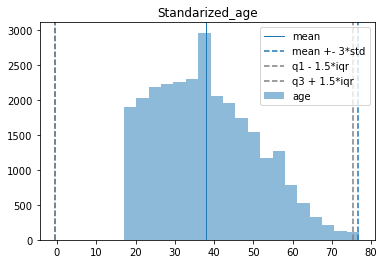

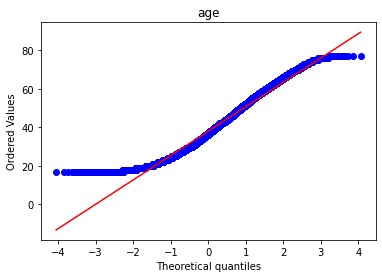

=== fnlwgt ===


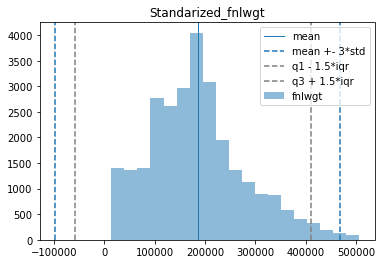

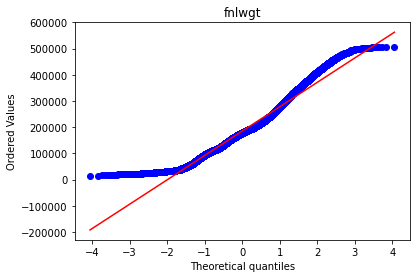

=== education-num ===


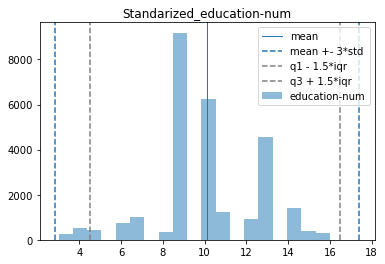

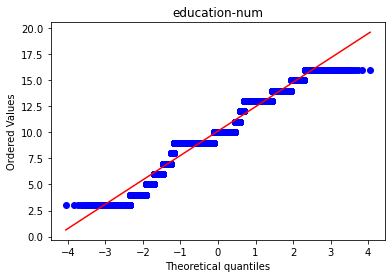

=== capital-gain ===


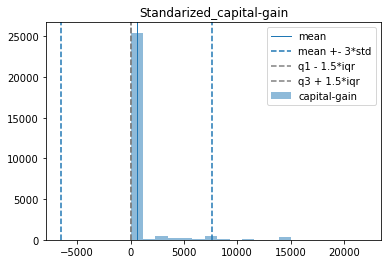

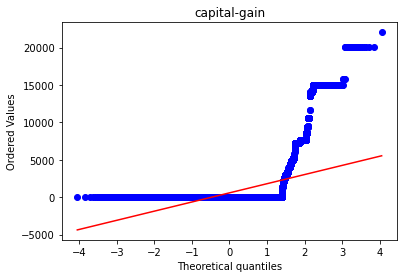

=== capital-loss ===


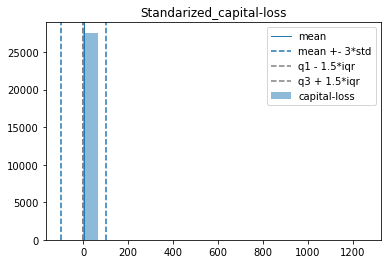

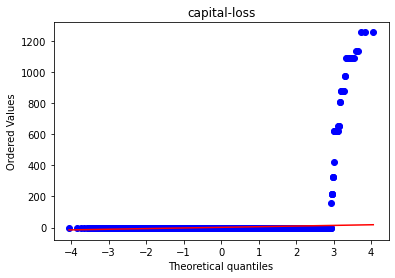

=== hours-per-week ===


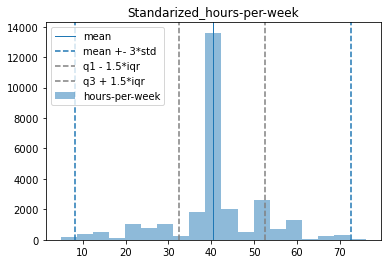

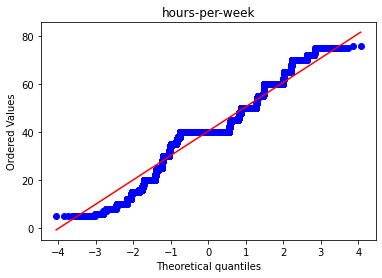

In [23]:
# check histogram and QQ plot after removing outliers
for col in numeric_cols:
    print('===', col, '===')
    histogram_title = 'Standarized_' + col
    plot_histogram(census_df_no_outlier, col, 20, histogram_title, savefig = True, outlierCount=False)
    plot_QQplot(census_df_no_outlier, col, col, savefig = False)
    print('================')

## (3) Transform the categorical variable to dummy variable

In [24]:
# Get dummies (if there's n classes, then create n-1 columns)
y = census_df_no_outlier['income'].replace({" <=50K": 0, " >50K": 1})
X = pd.get_dummies(census_df_no_outlier.drop(['income'], axis=1), drop_first=True)

## (4) “Randomly” split the dataset into training dataset and testing dataset

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('training:', Counter(y_train))

training: Counter({0: 16983, 1: 5113})


## (5) Use Logistic Regression to predict the “Class” in the testing dataset

In [26]:
# Choose a set of grids among a reasonable range, evaluated by f1 score.
# grids = [0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 80, 100]
grids = [0.05, 0.1, 0.5, 1, 5, 10, 20]
threshold_list = [0.3, 0.4, 0.5, 0.6, 0.7]

best_accuracy = 0
best_g = 0
best_threshold = 0

for g in grids:
    logic_tuning = LogisticRegression(C = g, tol = 1e-5, max_iter = 10000, penalty='l2')
    logic_tuning.fit(X_train, y_train)
    
    for i in threshold_list:
        y_pred = (logic_tuning.predict_proba(X_train)[:,1]>=i).astype(int)
        accuracy = accuracy_score(y_train, y_pred)
        
        if accuracy > best_accuracy:
            print(accuracy)
            best_accuracy = accuracy
            best_threshold = i
            best_g = g

logic_tuning_final = LogisticRegression(C = best_g, tol = 1e-5, max_iter = 10000)
logic_tuning_final.fit(X_train, y_train)
y_pred = (logic_tuning_final.predict_proba(X_test)[:,1]>=best_threshold).astype(int)

print('estimated parameters: ', best_g, best_threshold)
print('f1 score: ', f1_score(y_test, y_pred))
print('Accuracy score:', accuracy_score(y_test, y_pred))

0.6261766835626358
0.7385047067342505
0.7977009413468501
0.8005973931933381
0.8010047067342505
estimated parameters:  0.05 0.7
f1 score:  0.3067807768268598
Accuracy score: 0.8094117647058824


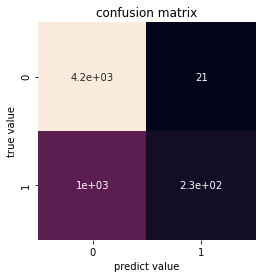

In [27]:
# confusion matirx
matric = confusion_matrix(y_test, y_pred)
sns.heatmap(matric,square=True,annot=True,cbar=False)
plt.xlabel("predict value")
plt.ylabel("true value")
plt.title("confusion matrix")
plt.show()

In [28]:
print(classification_report(y_test,y_pred,labels=[1,0],target_names=[">50K","<=50K"]))

              precision    recall  f1-score   support

        >50K       0.92      0.18      0.31      1265
       <=50K       0.80      1.00      0.89      4260

    accuracy                           0.81      5525
   macro avg       0.86      0.59      0.60      5525
weighted avg       0.83      0.81      0.76      5525



---
# 3. Association Rule- Market Basket Analysis

In [29]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder

import networkx as nx

## (1) Handle the raw dataset via data preprocessing

In [30]:
# Read file
with open('MDS_Assignment1_groceries.csv', newline='') as f:
    reader = csv.reader(f)
    dataset = list(reader)

In [31]:
# User TransactionEncoder function to do the one hot encoding into dataframe
te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
groceries_df = pd.DataFrame(te_ary, columns=te.columns_)
groceries_df

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,baby food,bags,baking powder,bathroom cleaner,beef,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9830,False,False,False,False,False,False,False,False,False,True,...,False,False,False,True,False,False,False,True,False,False
9831,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9832,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
9833,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## (2) What’s the top 5 association rules? Show the support, confidence, and lift to each specific rule, respectively

In [32]:
freq_item = apriori(groceries_df, min_support=0.001, use_colnames=True)

In [33]:
freq_item

,support,itemsets
0,0.008033,(Instant food products)
1,0.033452,(UHT-milk)
2,0.003559,(abrasive cleaner)
3,0.003254,(artif. sweetener)
4,0.017692,(baking powder)
...,...,...
13487,0.001017,"(other vegetables, root vegetables, whipped/so..."
13488,0.001017,"(other vegetables, root vegetables, tropical f..."
13489,0.001322,"(other vegetables, root vegetables, tropical f..."
13490,0.001322,"(rolls/buns, other vegetables, root vegetables..."


In [34]:
rules = association_rules(freq_item, metric='confidence', min_threshold=0.15)

In [35]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Instant food products),(butter),0.008033,0.055414,0.001220,0.151899,2.741145,0.000775,1.113765
1,(Instant food products),(curd),0.008033,0.053279,0.001322,0.164557,3.088583,0.000894,1.133196
2,(Instant food products),(hamburger meat),0.008033,0.033249,0.003050,0.379747,11.421438,0.002783,1.558640
3,(Instant food products),(other vegetables),0.008033,0.193493,0.002745,0.341772,1.766332,0.001191,1.225271
4,(Instant food products),(pastry),0.008033,0.088968,0.001423,0.177215,1.991899,0.000709,1.107254
...,...,...,...,...,...,...,...,...,...
32738,"(whole milk, root vegetables, whipped/sour cre...","(tropical fruit, other vegetables)",0.003660,0.035892,0.001118,0.305556,8.513141,0.000987,1.388315
32739,"(tropical fruit, whole milk, whipped/sour crea...","(root vegetables, other vegetables)",0.004372,0.047382,0.001118,0.255814,5.398992,0.000911,1.280081
32740,"(tropical fruit, root vegetables, whipped/sour...","(whole milk, other vegetables, yogurt)",0.004575,0.022267,0.001118,0.244444,10.977676,0.001017,1.294058
32741,"(root vegetables, whipped/sour cream, yogurt)","(tropical fruit, whole milk, other vegetables)",0.006406,0.017082,0.001118,0.174603,10.221561,0.001009,1.190843


In [36]:
rules.quantile(0.9)[["support","confidence","lift"]]

support       0.002949
confidence    0.586207
lift          6.065211
Name: 0.9, dtype: float64

### Top 5 association rules

In [37]:
top5_rules = rules[(rules["support"]>=0.0019) & (rules["confidence"]>=0.55) & (rules["lift"]>=6)].sort_values(by=["lift"], ascending=False)
top5_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
10188,"(processed cheese, ham)",(white bread),0.003050,0.042095,0.001932,0.633333,15.045491,0.001803,2.612469
2427,"(red/blush wine, liquor)",(bottled beer),0.002135,0.080529,0.001932,0.904762,11.235269,0.001760,9.654448
30966,"(fruit/vegetable juice, root vegetables, yogurt)","(whole milk, other vegetables)",0.003457,0.074835,0.002034,0.588235,7.860454,0.001775,2.246830
29945,"(tropical fruit, root vegetables, citrus fruit)","(whole milk, other vegetables)",0.005694,0.074835,0.003152,0.553571,7.397249,0.002726,2.072370
28467,"(tropical fruit, whole milk, other vegetables,...",(root vegetables),0.002949,0.108998,0.001932,0.655172,6.010840,0.001610,2.583904


In [38]:
# Descriptive statistics of nonnumeric columns
census_df.describe(exclude=[np.number])

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,income
count,30162,30162,30162,30162,30162,30162,30162,30162,30162
unique,7,16,7,14,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22286,9840,14065,4038,12463,25933,20380,27504,22654


## (4) Visualization graph of your association rules.

### Scater plot

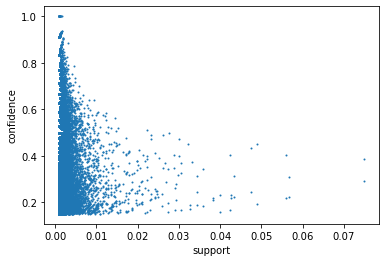

In [39]:
plt.scatter(rules["support"],rules["confidence"], 1)
plt.xlabel("support")
plt.ylabel("confidence")
plt.savefig('data_vis/supprt_confi.png')

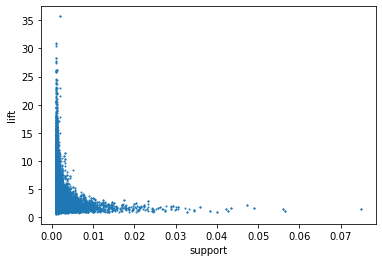

In [40]:
plt.scatter(rules["support"],rules["lift"], 1)
plt.xlabel("support")
plt.ylabel("lift")
plt.savefig('data_vis/supprt_lift.png')

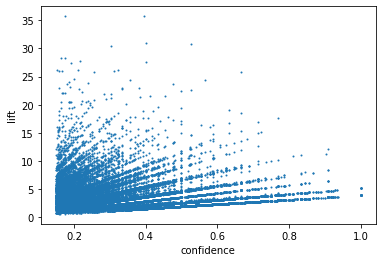

In [41]:
plt.scatter(rules["confidence"],rules["lift"], 1)
plt.xlabel("confidence")
plt.ylabel("lift")
plt.savefig('data_vis/lift_confi.png')

### Graph

In [42]:
def draw_graph(rule, fig_size = (20,20), fig_name = False):
    # 調整文字呈現方式
    update_rule = rule.copy()
    update_rule["antecedents"] = rules["antecedents"].apply(lambda x: ', '.join(list(x))).astype("unicode")
    update_rule["consequents"] = rules["consequents"].apply(lambda x: ', '.join(list(x))).astype("unicode")
    
    nodeSize = fig_size[0]*30
    fontSize = fig_size[0]/2
    edgeWidth = fontSize/4
    
    fig, ax = plt.subplots(figsize=fig_size)
    GA = nx.from_pandas_edgelist(update_rule, source='antecedents', target='consequents')
    pos = nx.spring_layout(GA)
    nx.draw_networkx_nodes(GA, pos, node_size = nodeSize, node_color = "orange")
    nx.draw_networkx_edges(GA, pos, width = edgeWidth, alpha = 0.5, edge_color = 'black')
    nx.draw_networkx_labels(GA, pos, font_size = fontSize, font_family = 'sans-serif')
    
    if fig_name != False:
        plt.savefig(fig_name)
        
    plt.show()

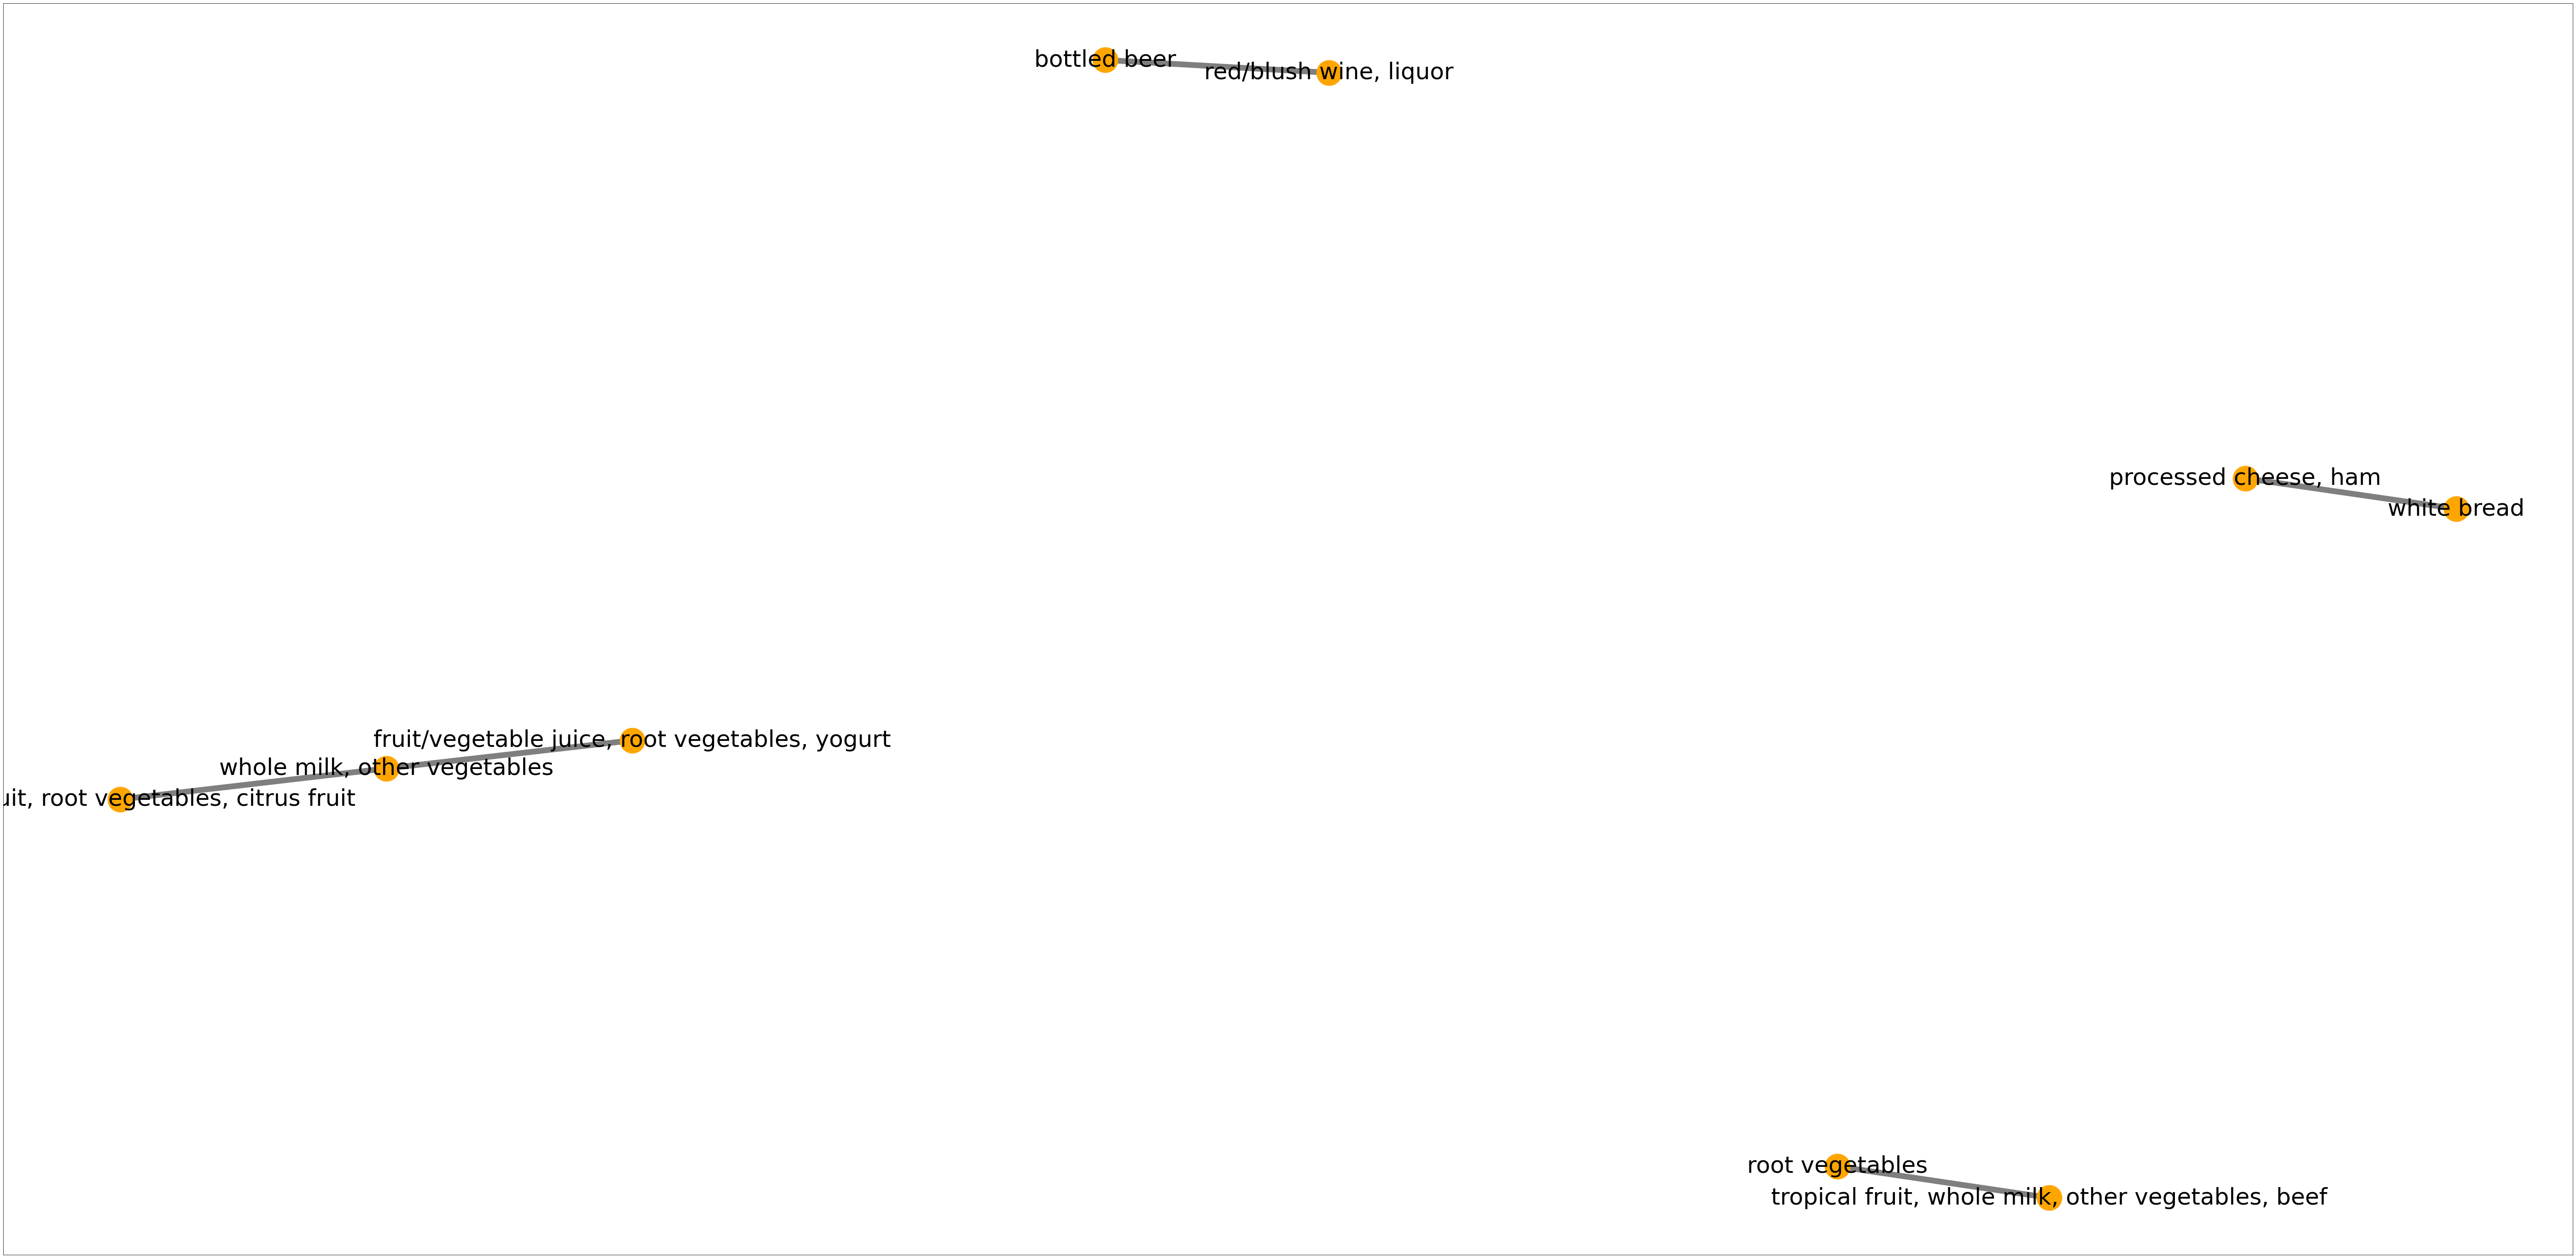

In [43]:
draw_graph(top5_rules, (100,50), fig_name='data_vis/top5_rule_graph.png')

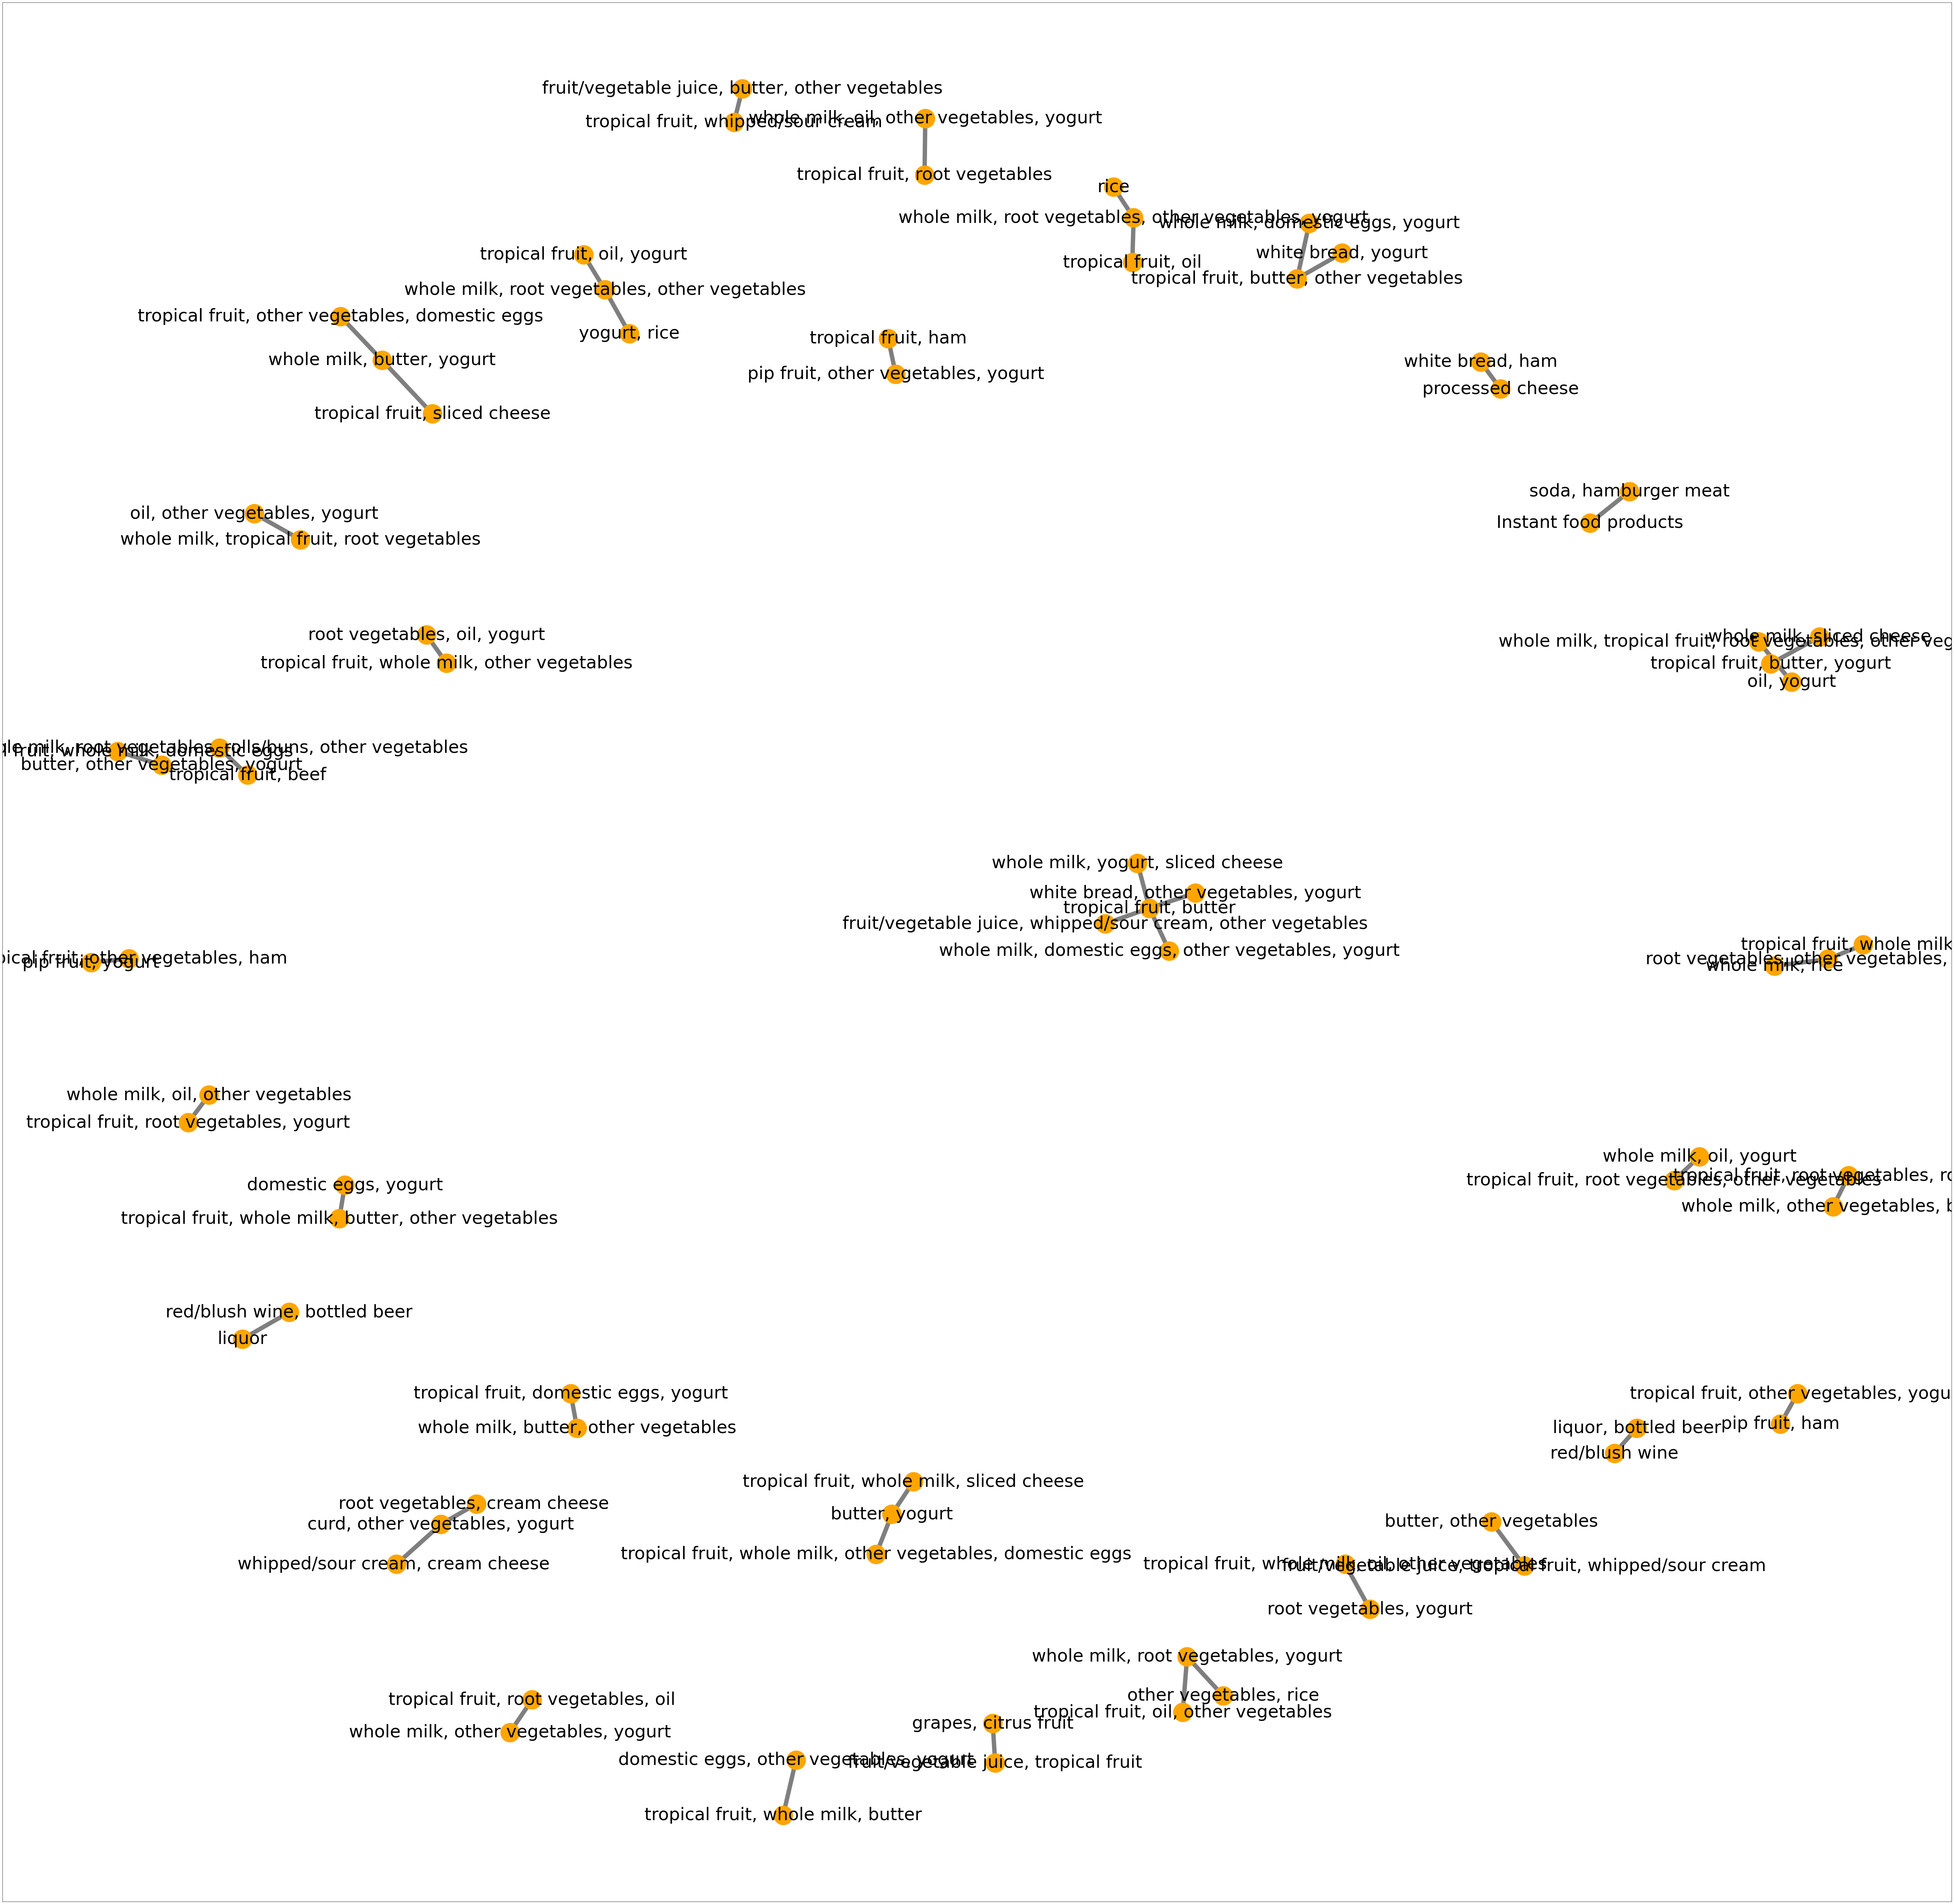

In [44]:
draw_graph(rules.sort_values(by=["lift"], ascending=False).head(50), (100,100), fig_name='data_vis/top50_rule_graph.png')